## MNIST Code with CNN
Now that we've seen the results of an artificial neural network model on the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a>, let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
 You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

***Please go this website: https://setosa.io/ev/ordinary-least-squares-regression/***

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

In [111]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

#### Load the MNIST dataset
PyTorch makes the MNIST train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

You are already familiar with transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [113]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [114]:
# Normalize the images to [0, 1] (equivalent to ToTensor in PyTorch)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Add channel dimension to match (N, H, W, 1) format
train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)

# Functionally equivalent to PyTorch's datasets.MNIST with ToTensor()
train_data = (train_images, train_labels)
test_data = (test_images, test_labels)

In [115]:
train_data.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [116]:
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28, 1)
<dtype: 'float32'>


In [117]:
test_data.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [118]:
print(test_images.shape)
print(test_images.dtype)

(10000, 28, 28, 1)
<dtype: 'float32'>


### Create loaders
When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [119]:
train_loader = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(10)
test_loader = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(10)

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong><br>

1. Extend the base Module class:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
The second layer will take our 6 input channels and deliver 16 output channels.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>
See below for a more detailed look at this step.<br><br>

4. Define the forward method.<br><br>Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>
<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
</font></tt>Flatten the data for the fully connected layers:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [125]:
# Define layers
conv1 = layers.Conv2D(6, (3, 3), strides=(1, 1), activation='relu')  # Equivalent to nn.Conv2d(1, 6, 3, 1)
conv2 = layers.Conv2D(16, (3, 3), strides=(1, 1), activation='relu')  # Equivalent to nn.Conv2d(6, 16, 3, 1)
max_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))  # Equivalent to F.max_pool2d

In [126]:
# Grab the first MNIST record
X_train = train_images[0:1]
X_train.shape  

TensorShape([1, 28, 28, 1])

In [127]:
# Perform the first convolution/activation
x = conv1(X_train) 
x.shape  

TensorShape([1, 26, 26, 6])

In [128]:
# Run the first pooling layer
x = max_pool(x)
x.shape

TensorShape([1, 13, 13, 6])

In [129]:
# Perform the second convolution/activation
x = conv2(x)
x.shape

TensorShape([1, 11, 11, 16])

In [130]:
# Run the second pooling layer
x = max_pool(x)
x.shape

TensorShape([1, 5, 5, 16])

In [131]:
# Flatten the data
x = tf.reshape(x, (-1, 5 * 5 * 16)) 
x.shape

TensorShape([1, 400])

<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [134]:
class ConvolutionalNetwork(tf.keras.Model):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = layers.Conv2D(6, (3, 3), strides=(1, 1), activation='relu')
        self.conv2 = layers.Conv2D(16, (3, 3), strides=(1, 1), activation='relu')
        self.flatten = layers.Flatten()  # Automatically flatten the output
        self.fc1 = layers.Dense(120, activation='relu')
        self.fc2 = layers.Dense(84, activation='relu')
        self.fc3 = layers.Dense(10)  # No activation here for use with sparse_categorical_crossentropy

    def call(self, X):
        X = self.conv1(X)
        X = layers.MaxPooling2D(pool_size=(2, 2))(X)
        X = self.conv2(X)
        X = layers.MaxPooling2D(pool_size=(2, 2))(X)
        X = self.flatten(X)  # Automatically flatten the output
        X = self.fc1(X)
        X = self.fc2(X)
        return tf.nn.log_softmax(self.fc3(X), axis=1)  # Apply log softmax to the output


In [135]:
# Set random seed for reproducibility
tf.random.set_seed(42)
model = ConvolutionalNetwork()
model.build((None, 28, 28, 1))  # Build the model with input shape
model.summary()

Model: "convolutional_network_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          multiple                  60        
                                                                 
 conv2d_17 (Conv2D)          multiple                  880       
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  48120     
                                                                 
 dense_16 (Dense)            multiple                  10164     
                                                                 
 dense_17 (Dense)            multiple                  850       
                                                                 
Total params: 60074 (234.66 KB)
Trainable p

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [136]:
def count_parameters(model):
    params = model.count_params()  # Count total parameters
    for layer in model.layers:
        if hasattr(layer, 'count_params'):
            print(f'{layer.count_params():>6}')  # Print parameters for each layer
    print(f'______\n{params:>6}')  # Print total parameters

In [137]:
count_parameters(model)

    60
   880
     0
 48120
 10164
   850
______
 60074


## Define loss function & optimizer

In [138]:
# Define loss function and optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [139]:
import time

In [140]:

# Training the model
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Apply the model
        with tf.GradientTape() as tape:
            y_pred = model(X_train)  # we don't flatten X_train here
            loss = criterion(y_train, y_pred)

        # Tally the number of correct predictions
        predicted = tf.argmax(y_pred, axis=1)
        batch_corr = tf.reduce_sum(tf.cast(predicted == tf.cast(y_train, tf.int64), tf.float32))
        trn_corr += batch_corr

        # Update parameters
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Print interim results
        if b % 600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10 * b:6}/60000]  loss: {loss.numpy():10.8f}  \
accuracy: {trn_corr.numpy() * 100 / (10 * b):7.3f}%')

    train_losses.append(loss.numpy())
    train_correct.append(trn_corr.numpy())

    # Run the testing batches
    for b, (X_test, y_test) in enumerate(test_loader):
        with tf.GradientTape() as tape:

            # Apply the model
            y_val = model(X_test)

        # Tally the number of correct predictions
        predicted = tf.argmax(y_val, axis=1)
        tst_corr += tf.reduce_sum(tf.cast(predicted == tf.cast(y_test, tf.int64), tf.float32))

    loss = criterion(y_test, y_val)
    test_losses.append(loss.numpy())
    test_correct.append(tst_corr.numpy())

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed


epoch:  0  batch:  600 [  6000/60000]  loss: 0.37061399  accuracy:  84.717%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.11857698  accuracy:  89.808%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.04116761  accuracy:  91.772%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00663823  accuracy:  92.892%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01811898  accuracy:  93.643%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.02519009  accuracy:  94.225%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.03924058  accuracy:  94.600%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00347457  accuracy:  94.985%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00146807  accuracy:  95.287%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.08211902  accuracy:  95.533%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.03107759  accuracy:  98.250%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.20072266  accuracy:  98.233%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.01821438  accuracy:  98.167%
epoch:  1  b

## Plot the loss and accuracy comparisons

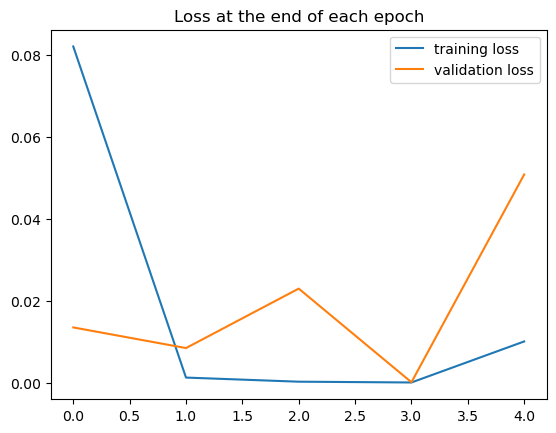

In [141]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [142]:
test_losses

[0.013533311, 0.00849444, 0.023007335, 0.0001483752, 0.050862867]

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

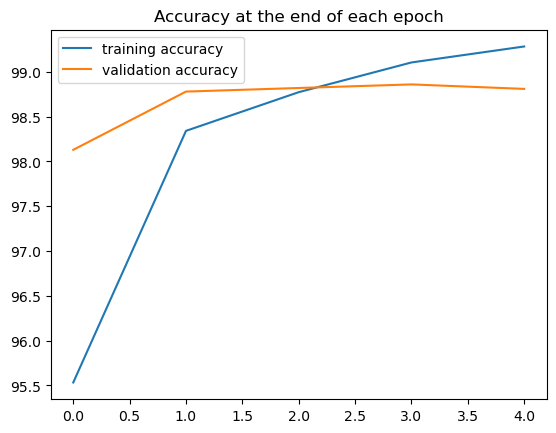

In [143]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [145]:
# Extract the data all at once, not in batches

In [144]:
test_load_all = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(10000)

In [146]:
correct = 0
total_samples = 0  # Initialize total sample count

# Iterate over the test dataset
for X_test, y_test in test_load_all:
    # Get model predictions
    y_val = model(X_test)  # Predictions from the model

    # Get the predicted classes
    predicted = tf.argmax(y_val, axis=1)

    # Convert y_test to the same type as predicted
    y_test = tf.cast(y_test, tf.int64)  # Ensure types match

    # Count correct predictions
    correct += tf.reduce_sum(tf.cast(predicted == y_test, tf.int32))

    # Increment total sample count
    total_samples += y_test.shape[0]  # Increment by batch size

# Calculate and print accuracy
test_accuracy = correct.numpy() * 100 / total_samples
print(f'Test accuracy: {correct.numpy()}/{total_samples} = {test_accuracy:7.3f}%')


Test accuracy: 9881/10000 =  98.810%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Display the confusion matrix

In [147]:
# Print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1, 10))
print()

# Assuming `predicted` and `y_test` are tensors containing the predicted and true labels
# Convert predicted and y_test to numpy arrays
predicted_np = predicted.numpy()  # Convert predicted tensor to numpy
y_test_np = y_test.numpy()        # Convert true labels tensor to numpy

# Print the confusion matrix using sklearn
conf_matrix = confusion_matrix(predicted_np, y_test_np)
print(conf_matrix)

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    2    3    0    0    2    5    0    2    0]
 [   0 1124    0    0    1    0    0    0    0    0]
 [   2    1 1017    1    3    0    0    6    3    1]
 [   0    0    3 1006    0    6    0    1    1    3]
 [   0    1    0    0  971    0    1    0    0    8]
 [   0    0    0    2    0  880    2    0    1    4]
 [   0    3    0    0    4    2  943    0    0    0]
 [   1    1    7    1    2    0    0 1020    5    5]
 [   3    3    2    0    0    2    7    1  962    4]
 [   0    0    0    0    1    0    0    0    0  984]]


## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [148]:
# `predicted` and `y_test` are tensors containing the predicted and true labels
misses = []

# Converting `predicted` and `y_test` to NumPy arrays if they are still tensors
predicted_np = predicted.numpy() if isinstance(predicted, tf.Tensor) else predicted
y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

# Iterating over the predictions and true labels
for i in range(len(predicted_np)):
    if predicted_np[i] != y_test_np[i]:
        misses.append(i)  # Directly appending the integer index

# Converting the list to a NumPy array and set the dtype to int64
misses = np.array(misses, dtype='int64')

len(misses)

119

In [149]:
# Display the first 10 index positions
misses[:10]

array([ 247,  321,  359,  444,  445,  448,  582,  583,  619,  659],
      dtype=int64)

In [47]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

In [150]:
# Setting up an iterator to feed batched rows
r = 12  # row size
row = iter(np.array_split(misses, len(misses)//r + 1))


In [151]:
next(row)

array([ 247,  321,  359,  444,  445,  448,  582,  583,  619,  659,  844,
        882], dtype=int64)

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

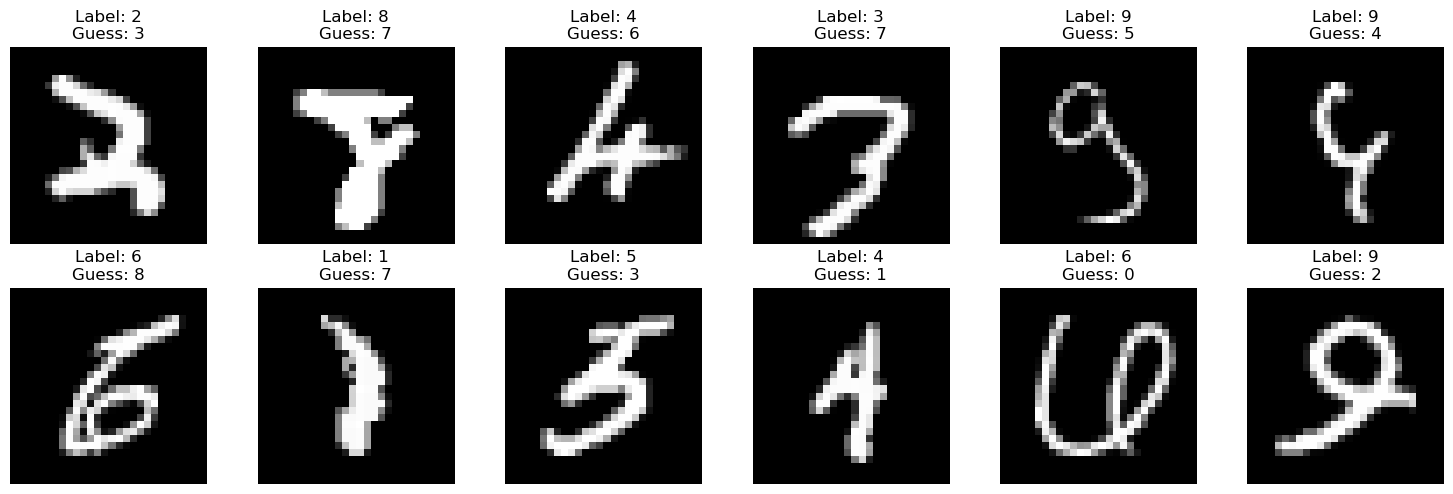

In [153]:
# Specify the indices you want to visualize
indices = next(row)

# Prepare the figure
num_images = len(indices)
cols = 6  # Number of columns for the grid
rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2.5))  # Adjust the figure size as needed

# Flatten the axs array for easier indexing
axs = axs.flatten()

for ax, index in zip(axs, indices):
    ax.imshow(X_test[index].numpy(), cmap='gray')  # Change 'gray' if images are not grayscale
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {y_test[index].numpy()}\nGuess: {predicted[index].numpy()}')  # Display label and prediction

# Hide any remaining empty subplots
for ax in axs[num_images:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [154]:
print("Shape of images:", images.shape)  # Should be something like (N, 28, 28, 1)


Shape of images: (1, 28, 28, 1)


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

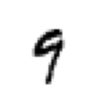

In [155]:
x = 2019

# Assuming test_data is a tuple of (images, labels)
# Get the image tensor and squeeze to (28, 28)
image = tf.squeeze(test_data[0][x])  # This will give you the shape (28, 28)

# Plot the image
plt.figure(figsize=(1, 1))
plt.imshow(image.numpy(), cmap="gist_yarg")  # Convert to NumPy array for plotting
plt.axis('off')  # Hide the axis
plt.show()

In [156]:
# Assuming test_data is a tuple of (images, labels)
image = tf.expand_dims(test_data[0][x], axis=0)  # Shape (1, 28, 28, 1)

# Make a prediction with the model
new_pred = model(image)  # Forward pass through the model
predicted_class = tf.argmax(new_pred, axis=-1)  # Get the class with the highest score

print("Predicted value:", predicted_class.numpy()[0])  # Convert to NumPy for display


Predicted value: 9


## Great job!